# Tutorial: Introduction to variational calculations. 

## Finding ground states.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/master/2304_Roscoff/variational_intro.ipynb)

Authors: Filippo Vicentini

This notebook is based on some classes given by Javier Moreno, Filippo Vicentini and Giuseppe Carleo at Flatiron Institute in 2022. It has been adapted for this website a while later by Filippo Vicentini.


## 0. Dependencies 

To run this tutorial, you will need to install [NetKet](https://www.netket.org/) and some other dependencies.
You can do so by removing the leading `#` in the following cell and running it.

The cell is commented by default such that if you have already installed all dependencies in your computer, it does not run by default all the time

In [1]:
# %pip install --quiet netket matplotlib

We also want make to sure that this notebook is running on the cpu. 
You can edit the field by changing "cpu" to "gpu" to make it run on the GPU if you want. 
But you'll need to use much larger systems to see a benefit in the runtime.
For systems with less than 40 spins GPUs slow you down remarkably.

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

## 1. Introduction to Quantum Mechanics:

If you are not very familiar with Quantum Physics, here's the main two postulates that we will be building upon: 

### 1. Wave-function
The state of an isolated physical system is represented, at a fixed time by the quantum state $|\psi\rangle$ (for our purposes a column vector) belonging to a Hilbert space $\mathcal {H}$ called the state space (for our purposes a vector space). 
$$
|\psi\rangle:=\begin{pmatrix}
                \psi_0 \\
                \psi_1 \\
                \vdots \\
                \psi_{M-1} \\
               \end{pmatrix}
$$
#### 1.a Composite Systems 
The Hilbert space of a composite system is obtained as the tensor product of the Hilbert spaces (Kronecker product for our purposes).

### 2. Observables
Every measurable physical quantity (position, velocity, energy...) is represented by a Hermitian operator  $O$ (Hermitian matrix has real eigenvalues!) acting on the Hilbert space. The expectation value of the physical quantity is given by the quadratic form [slides 1,2]:
$$
\langle\psi |O|\psi\rangle:= \begin{pmatrix}
                \psi_0^*, 
                \psi_1^*, 
                ..., 
                \psi_{M-1}^* 
               \end{pmatrix} 
               \begin{pmatrix} 
               O_{00} & O_{01} & ... \\
               O_{10} & \ddots & \vdots \\
               \vdots & ... & O_{M-1, M-1} \\
               \end{pmatrix}
               \begin{pmatrix}
                \psi_0 \\
                \psi_1 \\
                \vdots \\
                \psi_{M-1} \\
               \end{pmatrix}
$$


### 3. A simple example: a Spin-1/2 in a magnetic field

Let's consider a single spin-1/2 immersed in a magnetic field.
The Hilbert space of this problem has dimension 2, and a valid basis for it is $\{\uparrow, \downarrow\}$.

The hamiltonian for an external magnetic field is the following:

$$
H = -B \sigma^z := \begin{pmatrix}
                   -B & 0 \\
                   0 & B
                   \end{pmatrix}
$$

The energy of both basis states is thus given by:

$$
E_{\uparrow} = \langle \uparrow|H| \uparrow \rangle = \begin{pmatrix}
                1, 
                0  
               \end{pmatrix} 
               \begin{pmatrix} 
               -B & 0  \\
               0 & B 
               \end{pmatrix}
               \begin{pmatrix}
                1 \\
                0 \\
                \end{pmatrix}= -B 
$$

$$
E_{\downarrow} = \langle \downarrow|H| \downarrow \rangle = \begin{pmatrix}
                0, 
                1  
               \end{pmatrix} 
               \begin{pmatrix} 
               -B & 0  \\
               0 & B 
               \end{pmatrix}
               \begin{pmatrix}
                0 \\
                1 \\
                \end{pmatrix}= +B 
$$

Thus, the lowest energy state is $|\uparrow\rangle $.

**In general, the lowest energy state is the eigenvector of the lowest eigenvalue of $H$**.

### 4. Open Problems

In condensed matter physics we are often concerned with finding the ground-state of an Hamiltonian, which is the lowest-energy eingestate of the Hamiltonian.
This is not the **only** relevant problem (even if some people might argue otherwise!), but it is probably the most studied.
Some of the reasons why the ground-state is interesting are:

* The ground-state determines what is the stable configurations of the constituents of matter (atomic nuclei, molecular structure, reaction pathways...), for example telling us if two atoms form a bond or not.
* If you want to study what happens if you 'perturb' a system by turning on a magnetic field or another perturbation, the initial configuration will most likely be the ground-state.
* The eigenstate of lowest eigenvalue describes in good measure the physics of low temperatures (superconductivity).

## 2. Introduction to Variational Calculations


### 1. The problem
Consider a single spin-1/2 particle immersed in a magnetic field aligned along the physical $\hat{x}$ axis. 
Our task will be to compute the Ground-state energy of this system, whose Hamiltonian is:

$$
H = -B \sigma^x := \begin{pmatrix}
                   0 & -B \\
                   -B & 0
                   \end{pmatrix}
$$


The two eigenvectors and corresponding eigenvalues are given by:


$$
|\rightarrow\rangle := \frac{1}{\sqrt{2}}\begin{pmatrix}
                   1 \\
                   1
                   \end{pmatrix}; E_{\rightarrow} = -B
$$

$$
|\leftarrow\rangle := \frac{1}{\sqrt{2}}\begin{pmatrix}
                   1 \\
                   -1
                   \end{pmatrix}; E_{\leftarrow} = B
$$


Thus, the lowest energy of the system is given by:


$$
|\rightarrow\rangle := \frac{1}{\sqrt{2}}\begin{pmatrix}
                   1 \\
                   1
                   \end{pmatrix}
$$

Which is the state where the spin is aligned with the $\hat{x}$ axis. The lowest energy configuration (stable configuration) of a spin on an external magnetic field is the configuration where the spin is aligned with the magnetic field.

We can find the eigenvalues numerically by constructing the Hamiltonian 'by hand' as a matrix

In [3]:
# Numpy is used to work with 'dense' matrices, where we store all entries
import numpy as np

# magnetic field intensity
B = 3.
# The sigma_x operator acting on the single spin
sigma_x = np.array([[0,1], [1,0]])

# The resulting Hamiltonian
H = -B*sigma_x

And then by diagonalising the _dense_ matrix by using numpy:

In [4]:
# Diagonalise the matrix
Es, Vs = np.linalg.eigh(H)
# Es are the eigenvalues, Vs is a matrix whose columns Vs[:,i]
# correspond to the eigenvalues Es[i], and they are 'vectors'
# in the Hilbert space

print ('The resulting energies are: ' + str(Es))
print ('And the corresponding eigenvectors:')
print ('|-> > := ', Vs[:,0])
print ('|<- > := ', Vs[:,1])

The resulting energies are: [-3.  3.]
And the corresponding eigenvectors:
|-> > :=  [-0.70710678 -0.70710678]
|<- > :=  [-0.70710678  0.70710678]


So the ground-state is:

In [5]:
psi_gs_dense = Vs[:,0]

and it is a vector, as can be seen by inspecting its shape:

In [6]:
psi_gs_dense.shape

(2,)

### 2. The wave-function as a lookup table

You can see above that we printed the entries of the ground-state and of the excited state. 
The representation of the wave-function that we obtained by diagonalising the hamiltonian is a dense representation where the wave-funciton amplitude for every basis element ($\{\uparrow, \downarrow\}$) is stored, and you can _query_ those entries by calling

In [7]:
psi_gs_dense[0]

-0.7071067811865475

In [8]:
psi_gs_dense[1]

-0.7071067811865475

It might be 'redundant', but we could now construct a 'query function' that  returns the wave-funciton amplitude for a given configuration $i$.
This is a simple rewriting of what we just did in the two cells above, but you will later understand why it's important to think in terms of a function.

The query function for the ground-state will be:

In [9]:
def psi_gs(index: int) -> float:
    """
    Returns the i-th entry of the ground-state amplitude 
    along the sigma-z basis.
    """
    return psi_gs_dense[index]

According to the ordering we chose for our basis (see the first example), we have that the first element corresponds to $|\uparrow\rangle$ and the last element corresponds to $|\downarrow\rangle$.

So if we want to query $\langle\uparrow|\psi_{gs}\rangle$ we will have to execute `psi_gs(0)` and if we want to query $\langle\downarrow|\psi_{gs}\rangle$ we will have to execute `psi_gs(1)`

**This choice is completely arbitrary!**

### 3. The wave-function as a variational function:

Imagine that now we don't want to explicitly define each of the coordinates of my quantum vector (we will soon see why this might be useful). Instead of a lookup table, we define a function that takes as an input a numerical representation of the axis along we want a coordinate and returns the returns the corresponding coordinate:

$$
\psi(\sigma) = \cos\big(\theta(1-\sigma)\big),
$$

where we use the convention $\sigma = 1$ to signify the $\uparrow$ state and $\sigma = -1$ the $\downarrow$ state.

Therefore: 
$$
|\psi_\theta\rangle  := \frac{1}{N} \begin{pmatrix}
                   \cos\big(\theta(1-1)\big) \\
                   \cos\big(\theta(1-(-1))\big)
                   \end{pmatrix} = \frac{1}{\sqrt{1+\cos^2\big(2\theta\big)}} \begin{pmatrix} 1 \\
                   \cos\big(2\theta\big)
                   \end{pmatrix}                   
$$

In [10]:
# To be able to compute gradients, we will be using jax.numpy
# In practice, write your formulas by replacing np.**** with jnp.****
import jax.numpy as jnp

def psi(sigma, theta):
    return jnp.cos(theta*(1-sigma))

This is very similar to the previous look-up table, but if our angles are _fewer_ than the total number of complex amplitudes that I would have to store, I am saving up memory at the expense of not being able to represent _all_ possible states.

In a sense, you can think that $\theta$ identifies a specific wavefunction:
$$
    \Psi : \theta \rightarrow |\psi_\theta\rangle
$$
and once we have the wave-function $|\psi_\theta\rangle$ identified by a certain angle we can query it's entries even if we have not stored them anywhere.

#### Variational Energy 

Now the goal is to find the optimal value of $\theta$ such that the expectation value of the Hamiltonian is minimized. We will do a gradient based optimization using Jax.

To do this, first we must build the "energy" function that takes the angles identifying the current state and the hamiltonian and computes the energy:

In [11]:
def energy(theta, H):
    sigma_1 = 1
    sigma_2 = -1
    
    psi_vec = jnp.array([[psi(sigma_1, theta)], [psi(sigma_2, theta)]])
    # note we are normalizing the wave function here!
    psi_vec = psi_vec/jnp.sqrt(jnp.sum(psi_vec**2)) 
        
    return jnp.dot(jnp.transpose(psi_vec), jnp.dot(H, psi_vec))[0,0]

Then we evaluate the energy for many possible values of $\theta\in[0,2\pi]$

In [12]:
thetas = np.linspace(0, 2*np.pi, 100)
energies = [energy(θ, H) for θ in thetas]

And finally we plot the energy as a function of the parameter $\theta$

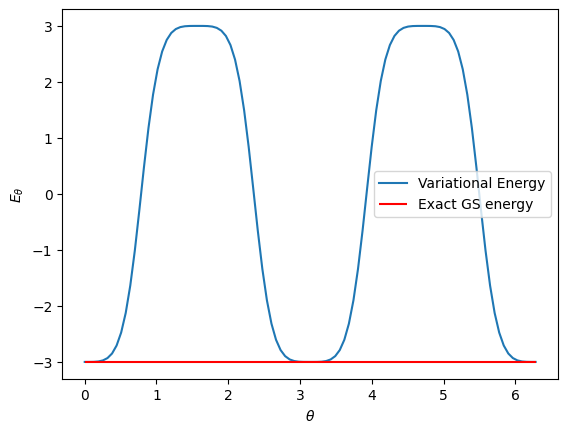

In [13]:
import matplotlib.pyplot as plt

plt.plot(thetas, energies, label="Variational Energy")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$E_\theta$')
plt.hlines(Es[0], 0, thetas[-1], label="Exact GS energy", color='red')
plt.legend();

### 4. Optimising the energy

Now the goal is to find the optimal value of $\theta$ such that the expectation value of the Hamiltonian is minimized. We will do a gradient based optimization using Jax.

The gradient of a function in Jax can be computed by using the `jax.grad` function, which essentially does the following:

$$
    \text{jax.grad} : f \rightarrow \nabla f
$$

and in our particular case we can do the following:


In [14]:
import jax
from tqdm import tqdm

#argnums=0 determines the index of the arguments w.r.t which the derivative is computed.
# We want the gradient w.r.t the parameters, which is the first argument, so we put 0.
# if we wanted the derivative w.r.t the hamiltonian we would have to put `argnums=1`
energy_derivative = jax.grad(energy, argnums=0)

And now we can try a sample optimisation starting from the initial value of $\theta_0 = 2.$ and updating the angle according to the formula

$$
    \theta_{i+1} = \theta_i - \eta \nabla_\theta E(\theta_i)
$$

where $\nabla$ is the so-called learning rate

In [15]:
#learning rate
nabla = 0.01

#number of steps
n_steps = 100

#initial value for the variational parameter
theta = 2.

#To store the value of the energy and the valiarional paramter during the optimization
energy_history = np.zeros(n_steps)
theta_history = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    
    # log the variational parameter and the energy
    theta_history[i] = theta
    energy_history[i] = energy(theta, H)
    
    # update the variational parameter according to gradient descent
    theta -= nabla * energy_derivative(theta, H)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 106.39it/s]


And by plotting, we can see that the energy goes down as we continue to apply our algorithm.

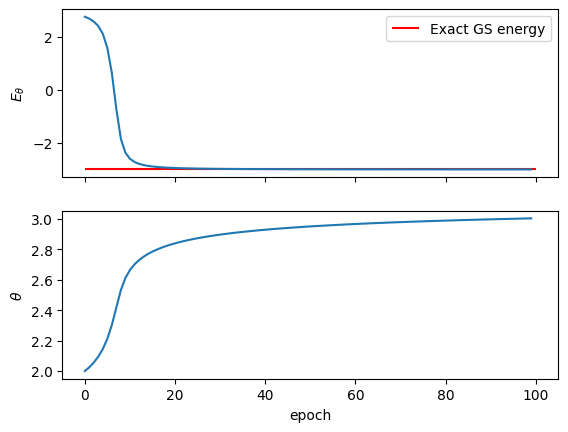

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)

ax1.hlines(Es[0], 0, 100, label="Exact GS energy", color='red')
ax1.plot(energy_history)
ax1.set_ylabel(r'$E_\theta$')
ax1.legend()

ax2.plot(theta_history)
ax2.set_ylabel(r'$\theta$')
ax2.set_xlabel(r'epoch');

### 5. More complex ansatz: 2 parameters

Let's now try with a more complex Ansatz

$$
\psi_\theta(\sigma) = \cos\big(\theta_1(1+\sigma)\big) + \exp\big(\theta_2(1-\sigma)\big)
$$

Therefore: 

$$
|\psi_\theta\rangle  := \frac{1}{N} \begin{pmatrix}
                   \cos\big(\theta_1(1+1)\big) + \exp\big(\theta_2(1-1)\big) \\
                   \cos\big(\theta_1(1-1)\big) + \exp\big(\theta_2(1+1)\big)
                       \end{pmatrix} = \frac{1}{N} \begin{pmatrix}\cos\big(2\theta_1\big) + 1 \\
                   1 + \exp\big(2\theta_2\big)
                   \end{pmatrix}                   
$$

In [17]:
import jax.numpy as jnp

def psi(sigma, theta):
    psi = (jnp.cos(theta[0]*(1+sigma))+jnp.exp(theta[1]*(1-sigma))) 
    return psi

As we wrote the energy function carefully, we can recycle it. 
Let's explore the energy landscape by computing the energy for every possible value of the parameters.

In [18]:
# First we discretise a grid for theta_1 and theta_2
thetas_1 = np.linspace(0, 2*np.pi, 50)
thetas_2 = np.linspace(-10, 2, 50)
# We pre-allocate the output array
energies = np.empty((50, 50))

for i in range(len(thetas_2)):
    for j in range(len(thetas_1)):
        energies[i, j] = energy(jnp.array([thetas_1[j], thetas_2[i]]), H)

And we plot the surface

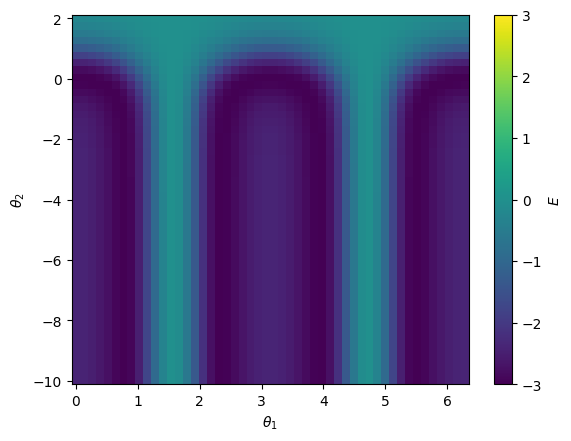

In [19]:
x, y = np.meshgrid(thetas_1, thetas_2)

c = plt.pcolormesh(x, y, energies, cmap = 'viridis', vmax = 3, vmin = -3)

cbar = plt.colorbar(c)
cbar.set_label(r'$E$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

or in 3D

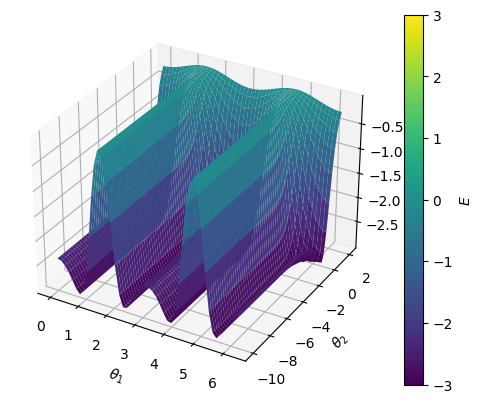

In [20]:
x, y = np.meshgrid(thetas_1, thetas_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
c = ax.plot_surface(x, y, energies, cmap = 'viridis', vmax = 3, vmin = -3)

cbar = plt.colorbar(c)
cbar.set_label(r'$E$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

In general, however, we cannot look at the potential energy surface. In this case we will be using an iterative
optimisation scheme to find the ground-state energy, like we did before

In [21]:
#compute energy derivative for the new ansatz
energy_derivative = jax.grad(energy, 0) #zero because we only want derivative with respect to 1st positional argument

#learning rate
lr = 0.01

#number of steps
n_steps = 200

#initial value for the variational parameter
theta = jnp.array([1.6, 1.])

#To store the value of the energy and the valiarional paramter during the optimization
energy_history = np.zeros(n_steps)
theta_history = np.zeros((n_steps, 2))
for i in tqdm(range(n_steps)):
    
    #log the variational parameter and the energy
    theta_history[i, :] = theta
    energy_history[i] = energy(theta, H)
    
    #update the variational parameter according to gradient descent
    theta -= lr * energy_derivative(theta, H)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.65it/s]


And plotting the energy as a function of the iteration

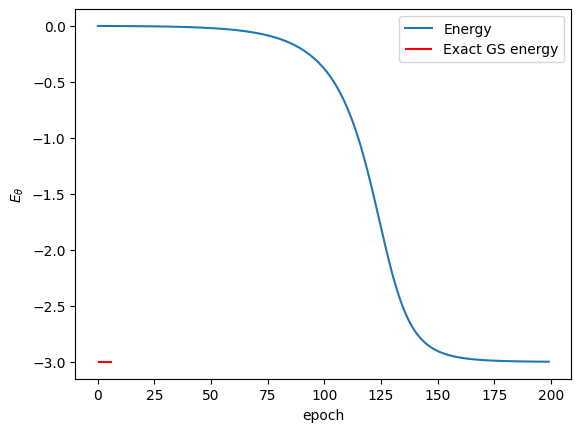

In [22]:
plt.plot(energy_history, label='Energy')
plt.ylabel(r'$E_\theta$')
plt.xlabel(r'epoch')
plt.hlines(Es[0], 0, thetas[-1], label="Exact GS energy", color='red')
plt.legend();

We can also investigate how it looks like in the parameter space

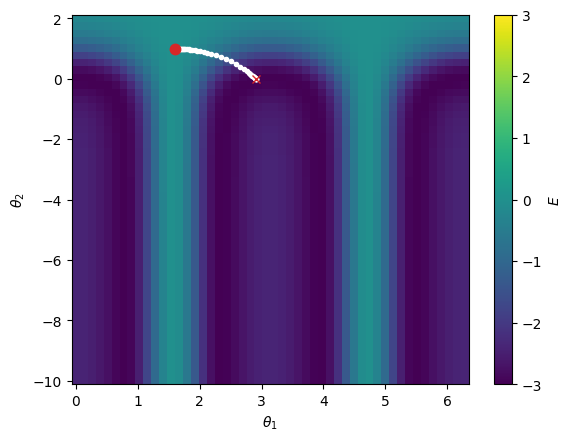

In [23]:
x, y = np.meshgrid(thetas_1, thetas_2)

c = plt.pcolormesh(x, y, energies, cmap = 'viridis', vmax = 3, vmin = -3)
plt.plot(theta_history[::4, 0], theta_history[::4, 1], marker = '.', c = 'w')
plt.plot(theta_history[0, 0], theta_history[0, 1], marker = '.', markersize = 15, c = 'tab:red')
plt.plot(theta_history[-1, 0], theta_history[-1, 1], marker = 'x', c = 'tab:red')

cbar = plt.colorbar(c)
cbar.set_label(r'$E$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

### 3. Going towards Monte-Carlo sampling of the Energy

Until now we have computed the energy as the _full summation_
$$
E(\theta) = \sum_{\sigma, \eta} \psi^\star(\sigma) \langle \sigma|H|\eta\rangle \psi(\eta)
$$

But let's try to rewrite those estimators as 
$$
E(\theta) = \sum_\sigma p(\sigma) E^{loc}(\sigma)
$$
where
$$
p(\sigma) =  \frac{|\psi(\sigma)|^2}{\sum_\sigma|\psi(\sigma)|^2} \,\,\,\,\,\,\,\, E^{loc}(\sigma)=\sum_\eta \langle \sigma|H|\eta\rangle\frac{\psi(\eta)}{\psi(\sigma)}
$$

Specifically, we will study the transverse-field Ising model in one dimension: 

$$ 
\mathcal{H}=\Gamma\sum_{i}\sigma_{i}^{(x)}+V\sum_{i}\sigma_{i}^{(z)}\sigma_{i+1}^{(z)}. 
$$

In the following we assume periodic boundary conditions and we will count lattice sites starting from $ 0 $, such that $ i=0,1\dots L-1 $ and $i=L=0$. 

### 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). 
This is done specifying the Hilbert space of the problem. For example, let us concentrate on a problem with 20 spins-1/2.

When building hilbert spaces, in general, the first argument determines the size of the local basis and the latter defines how many modes you have.

In [24]:
import netket as nk

N = 20
hi = nk.hilbert.Spin(s=1 / 2, N=N)

NetKet's Hilbert spaces define the computational basis of the calculation, and are used to label and generate elements from it. 
The standard Spin-basis implicitly selects the `z` basis and elements of that basis will be elements $ v\in\{\pm 1\}^N $.

It's possible to enumerate the elements in the basis by calling `hi.all_states`

In [25]:
print(hi.all_states().shape)
hi.all_states()

(1048576, 20)


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

And you can always convert those configurations to an index:

In [26]:
hi.states_to_numbers(hi.all_states())

array([      0,       1,       2, ..., 1048573, 1048574, 1048575])

We now need to specify the Hamiltonian. For this purpose, we will use NetKet's ```LocalOperator``` (see details [here](https://www.netket.org/docs/_generated/operator/netket.operator.LocalOperator.html#netket.operator.LocalOperator)) which is the sum of arbitrary k-local operators. 

In this specific case, we have a 1-local operator, $ \sigma^{(x)}_i $ and a 2-local operator, $ \sigma^{(z)}_i \sigma^{(z)}_j $. We then start importing the pauli operators. 



In [27]:
from netket.operator.spin import sigmax,sigmaz 

We now take $ \Gamma=-1 $ and start defining the 1-local parts of the Hamiltonian 

In [28]:
Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

Here we have used a list comprehension to (mildly) show off our ability to write one-liners, however you could have just added the terms one by one in an explicit loop instead (though you'd end up with a whopping 3 lines of code). 

We now also add the interaction terms, using the fact that NetKet automatically recognizes products of local operators as tensor products. 

In [29]:
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

### 2. Exact Diagonalization

Now that we have defined the Hamiltonian, we can already start playing with it. For example, since the number of spins is large but still manageable for exact diagonalization, we can give it a try. 

In NetKet this is easily done converting our Hamiltonian operator into a sparse matrix of size $ 2^N \times 2^ N $. 

In [30]:
sp_h=H.to_sparse()
sp_h.shape

(1048576, 1048576)

Since this is just a regular scipy sparse matrix, we can just use any sparse diagonalization routine in there to find the eigenstates. For example, this will find the two lowest eigenstates  

In [31]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-25.49098969 -25.41240947]


### 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i), $$

where the variational parameters are the single-spin wave functions, which we can further take to be normalized: 

$$ |\Phi(\uparrow)|^2 + |\Phi(\downarrow)|^2 =1, $$

and we can further write $ \Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}$. In order to simplify the presentation, we take here and in the following examples the phase $ \phi=0 $. In this specific model this is without loss of generality, since it is known that the ground state is real and positive. 

For the normalized single-spin probability we will take a sigmoid form: 

$$ P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z)), $$

thus depending on the real-valued variational parameter $\lambda$. 
In NetKet one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).
We call this variational function _the Model_ (yes, caps on the M).

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right], $$

where $\theta$ is a set of parameters. 
In this case, the parameter of the model will be just one: $\gamma$.  

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku. 
NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), so we will be using it for the rest of the notebook. 

In [32]:
# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(lam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To actually create a variational state with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State. 
To do this, we first need to define a sampler.

In [33]:
# Create an instance of the model. 
# Notice that this does not create the parameters, but only the specification of how the model is constructed and acts upon inputs/.
mf_model = MF()

In [34]:
init_rng = jax.random.PRNGKey(0)
pars = mf_model.init(init_rng, hi.numbers_to_states(2))

The parameters are stored as a set of nested dictionaries. In this case, the single parameter $\lambda$ is stored inside a (frozen) dictionary.
(The reason why the dictionary is frozen is a detail of Flax).

In [35]:
pars

FrozenDict({
    params: {
        lambda: Array([-0.02033396], dtype=float64),
    },
})

The wave-function can be queried for every possible value in the Hilbert space by using the following syntax:

In [36]:
sigmas = hi.all_states()

log_wf_amplitudes = mf_model.apply(pars, sigmas)

wf_amplitudes = jnp.exp(log_wf_amplitudes)

And this is not normally normalized, but for the particular ansatz we picked it is:

In [37]:
jnp.linalg.norm(wf_amplitudes)

Array(1., dtype=float64)

We can also make the function to construct the full wavefunction:

In [38]:
def dense_wavefunction(params):
    sigmas = hi.all_states()
    log_wf_amplitudes = mf_model.apply(pars, hi.all_states())
    return jnp.exp(log_wf_amplitudes)/jnp.linalg.norm(wf_amplitudes)

### 4. Compute the Born Probability Amplitude

We want to compute 
$$
p(\sigma) =  \frac{|\psi(\sigma)|^2}{\sum_\sigma|\psi(\sigma)|^2}
$$

In [39]:
def born_amplitude(pars, x):
    log_wf_amplitudes = mf_model.apply(pars, x)
    probs = jnp.exp(2*log_wf_amplitudes.real)
    return probs/probs.sum()

And we can check that it works:

In [40]:
born_amplitude(pars, sigmas)

Array([1.16750958e-06, 1.14400922e-06, 1.14400922e-06, ...,
       7.93364614e-07, 7.93364614e-07, 7.77395278e-07], dtype=float64)

In [41]:
born_amplitude(pars, hi.all_states()).sum()

Array(1., dtype=float64)

### 5. Compute the Local Energies

We want to compute 
$$
 E^{loc}(\sigma)=\sum_\eta \langle \sigma|H|\eta\rangle\frac{\psi(\eta)}{\psi(\sigma)}
$$

In [42]:
# First we identify the non-zero elements
sigmas = hi.numbers_to_states(np.arange(20))
print(sigmas.shape)

(20, 20)


In [43]:
# then we use:
etas, mels = H.get_conn_padded(sigmas)
print("eta shape:", etas.shape)
print("mels shape:", mels.shape)

eta shape: (20, 21, 20)
mels shape: (20, 21)


In [44]:
# We compute the local energy as:
logpsi_eta = mf_model.apply(pars, etas)
print(logpsi_eta.shape)

logpsi_sigma = mf_model.apply(pars, sigmas)
print(logpsi_sigma.shape)
logpsi_sigma = jnp.expand_dims(logpsi_sigma, axis=-1)
print(logpsi_sigma.shape)

(20, 21)
(20,)
(20, 1)


In [45]:
Eloc = jnp.sum(mels*jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
print(Eloc.shape)

(20,)


And we try to put those elements together in a single function:

In [46]:
def local_energy(pars, sigmas):
    etas, mels = H.get_conn_padded(sigmas)
    logpsi_eta = mf_model.apply(pars, etas)
    logpsi_sigma = mf_model.apply(pars, sigmas)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, axis=-1)
    Eloc = jnp.sum(mels*jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    return Eloc

### 6. Compute the Energy with a _full summation_

But let's try to rewrite those estimators as 
$$
E(\theta) = \sum_\sigma p(\sigma) E^{loc}(\sigma)
$$

In [47]:
all_sigmas = hi.all_states()
energy_fullsum = jnp.sum(born_amplitude(pars, all_sigmas) * local_energy(pars, all_sigmas))
print("Full summation energy:", energy_fullsum)

Full summation energy: -20.00103357712735


And we can compare against the exact 'energy'

In [48]:
psi = dense_wavefunction(pars)
hmat = H.to_sparse()
energy_exact = psi.conj().T@hmat@psi
print("Full summation energy:", energy_exact)

Full summation energy: -20.001033577108004


### 7. Using Monte Carlo sampling

Now let's try to reduce the computational cost by using stochastic sampling.
To do that we will use NetKet's samplers...

In `netket.sampler` several samplers are defined, each with its own peculiarities. 
In the following example, we will be using a simple sampler that flips the spins in the configurations one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

In [49]:
# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

In [50]:
# Initialize the sampler
sampler_state = sampler.reset(mf_model, pars)

In [51]:
# generate samples
samples, sampler_state_2 = sampler.sample(mf_model, pars, state=sampler_state, chain_length=100)

In [52]:
print(samples.shape)

(100, 16, 20)


And now we use

$$
E(\theta) = \sum_\sigma p(\sigma) E^{loc}(\sigma) \approx \frac{1}{N_s}\sum_{\sigma\in\{...\}} E^{loc}(\sigma)
$$


In [53]:
samples, sampler_state_2 = sampler.sample(mf_model, pars, state=sampler_state, chain_length=100)
energy_sampled = jnp.mean(local_energy(pars, samples))
print("Full summation energy:", energy_sampled)

Full summation energy: -20.086649097794574


In [57]:
N_samples = [ 10,50, 100,250, 500,800, 1000,2000, 3000, 5000]
energies = []
for Ns in N_samples:
    samples, sampler_state_2 = sampler.sample(mf_model, pars, state=sampler_state, chain_length=Ns)
    energy_sampled = jnp.mean(local_energy(pars, samples))
    energies.append(energy_sampled)

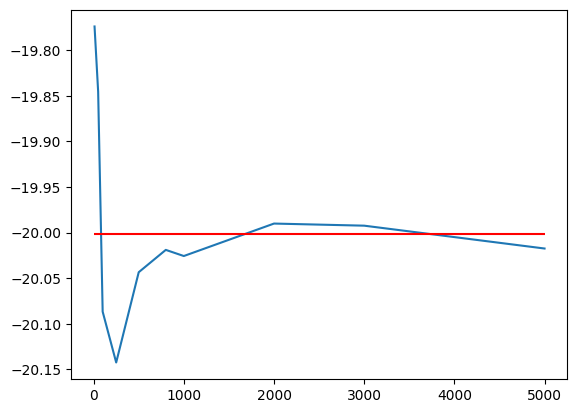

In [58]:
plt.plot(N_samples, energies)
plt.hlines(energy_fullsum, 0, N_samples[-1], color='red')

## 3. Easier Interface

What you've seen above is complex, and often we don't want to deal with all that...
For that reason netket implements a 'variational state' interface that hides all those details (and more)

In [59]:
# Create an instance of the model. 
# Notice that this does not create the parameters, but only the specification of how the model is constructed and acts upon inputs/.
mf_model = MF()

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=512)

You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters.
The parameters are stored as a set of nested dictionaries. In this case, the single parameter $\lambda$ is stored inside a (frozen) dictionary.
(The reason why the dictionary is frozen is a detail of Flax).

In [60]:
print(vstate.parameters)

FrozenDict({
    lambda: Array([0.01302737], dtype=float64),
})


With a variational state, you can compute expectation values of operators. 
Notice that it also provides an error estimate and the variance of this estimator. 
If you are close to an eigenstate of the operators, the variance should be 0 or close to 0. 

The $\hat{R}$ value is a Monte-Carlo convergence estimator. It will be $\hat{R}\approx 1$ if the Markov Chain is converged, while it will be far from $1$ if your sampling has not converged.
As a rule of thumb, look out for $|\hat{R}| > 1.1$, and check if your sampling scheme or sampler is consistent with your system specification.

You can also investigate the correlation time of your estimator, $\tau$. If $\tau\gg1$ then your samples are very correlated and you most likely have some issues with your sampling scheme.

In [61]:
E = vstate.expect(H)
print(E)

-19.67 ± 0.18 [σ²=19.58, R̂=1.0151, τ=0.8<3.6]


You can also access the fields individually:
Note that if you run your calculation using MPI on different processes/machines, those estimators will return the mean, error and estimators of all the samples across all the processes.

In [62]:
print("Mean                  :", E.mean)
print("Error                 :", E.error_of_mean)
print("Variance              :", E.variance)
print("Convergence indicator :", E.R_hat)
print("Correlation time      :", E.tau_corr)

Mean                  : -19.6715613988669
Error                 : 0.1764822181784137
Variance              : 19.576092552811293
Convergence indicator : 1.0151073782385118
Correlation time      : 0.7922668561088076


In [63]:
vstate.expect_and_grad(H)

(-19.67 ± 0.18 [σ²=19.58, R̂=1.0151, τ=0.8<3.6],
 FrozenDict({
     lambda: Array([-0.11236042], dtype=float64),
 }))

## 4. Variational Monte Carlo

We will now try to optimise $ \lambda $ in order to best approximate the ground state of the hamiltonian.

At first, we'll try to do this by ourselves by writing the training loop, but then we'll switch to using a pre-made
solution provided by netket for simplicity.

### 4a. DIY Optimisation loop

The optimisation (or training) loop must do a very simple thing: at every iteration it must compute the energy and it's gradient, then multiply the gradient by a certain learning rate $\lambda = 0.05$ and lastly it must update the parameters with this rescaled gradient.
You can do so as follows:

In [64]:
from tqdm import tqdm

energy_history = []
n_steps = 100

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_map(lambda x,y: x-0.05*y, vstate.parameters, E_grad)
    # actually update the parameters
    vstate.parameters = new_pars

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.12it/s]


We now can plot the energy during those optimisation steps:


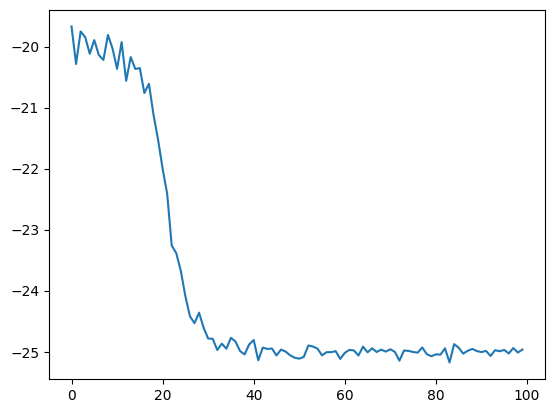

In [65]:
import matplotlib.pyplot as plt

plt.plot(energy_history)

### 4b. Use NetKet's optimisation driver 

As writing the whole optimisation loop by yourself every time is.. boring, we can make use of a coupled of NetKet's built-in utilities.

In [66]:
# First we reset the parameters to run the optimisation again
vstate.init_parameters()

# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

mf_energy=vstate.expect(H)
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|██████████████████████████████████████████████████████| 300/300 [00:04<00:00, 64.02it/s, Energy=-24.984 ± 0.028 [σ²=1.040, R̂=1.0163, τ=0.9<2.3]]


Optimized energy and relative error:  -24.974 ± 0.039 [σ²=0.985, R̂=1.0140, τ=0.6<1.9] 0.02026359317628221


In [67]:
# we can also inspect the parameter:
print("Final optimized parameter: ",vstate.parameters["lambda"])

Final optimized parameter:  [-2.6384457]


In [68]:
eig_vals[0]

-25.490989686364735

## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about 2% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz. 

We will now take a short-range Jastrow ansatz, entangling nearest and next-to nearest neighbors, of the form 

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp \left( \sum_i J_1 \sigma^{z}_i\sigma^{z}_{i+1} + J_2 \sigma^{z}_i\sigma^{z}_{i+2} \right),$$

where the parameters $J_1$ and $J_2$ are to be learned. 

Again we can write the model using flax. 

In [69]:
class JasShort(nn.Module):
    @nn.compact
    def __call__(self, x):
        
        # Define the two variational parameters J1 and J2
        j1 = self.param(
            "j1", nn.initializers.normal(), (1,), float
        )
        j2 =self.param(
            "j2", nn.initializers.normal(), (1,), float
        )

        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(j1*corr1+j2*corr2,axis=-1)
    
model=JasShort()

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner. Also, we now log the intermediate results of the optimization, so that we can visualize them at a later stage. 

Loggers that work together with optimisation drivers are defined in `nk.logging`. In this example we use `RuntimeLog`, which keeps the metrics in memory. You could also use `JsonLog`, which stores data to a json file which can be later read as a dict or `TensorBoardLog` which connects to [TensorBoard](https://www.tensorflow.org/tensorboard).

In [70]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

# construct the logger
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)

print(f"Final optimized parameters: j1={vstate.parameters['j1']}, j2={vstate.parameters['j2']}")

jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error}")

100%|██████████████████████████████████████████████████████| 300/300 [00:03<00:00, 81.00it/s, Energy=-25.306 ± 0.026 [σ²=0.369, R̂=1.0178, τ=1.5<2.9]]


Final optimized parameters: j1=[0.2335846], j2=[0.08119685]
Optimized energy : -25.293 ± 0.028 [σ²=0.413, R̂=1.0193, τ=1.5<3.0]
relative error   : 0.007764053809496511


You can now see that this ansatz is almost one order of magnitude more accurate than the mean field! 

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, here we have just used a simple one that stores the intermediate results as values in a dictionary. 

In [71]:
data_jastrow = log.data
print(data_jastrow)

{'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr', 'TauCorrMax'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.  

Text(0, 0.5, 'Energy')

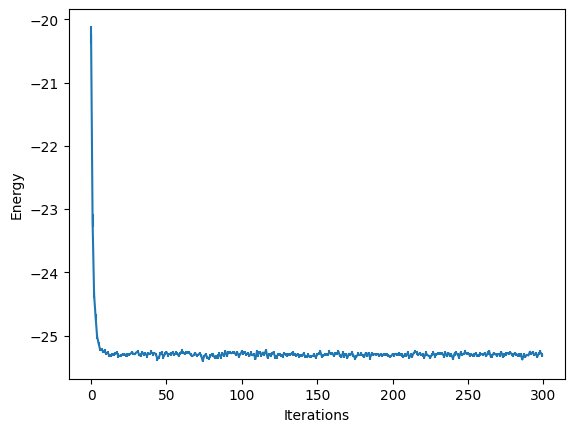

In [72]:
from matplotlib import pyplot as plt

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma)
plt.xlabel('Iterations')
plt.ylabel('Energy')

## 6. Neural-Network Quantum State 

We now want to use a more sophisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation. 

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer. 

In [73]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
                
        # sum the output
        return jnp.sum(y, axis=-1)
    
model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

We then proceed to the optimization as before. 

In [74]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

ffn_energy=vstate.expect(H)
error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",ffn_energy,error)

100%|██████████████████████████████████████████████████████| 300/300 [00:06<00:00, 46.53it/s, Energy=-25.471 ± 0.012 [σ²=0.102, R̂=1.0135, τ=1.0<2.6]]


Optimized energy and relative error:  -25.479 ± 0.011 [σ²=0.095, R̂=1.0133, τ=1.1<3.5] 0.00045109957224080465


And we can compare the results between the two different Ansätze:

Text(0, 0.5, 'Energy')

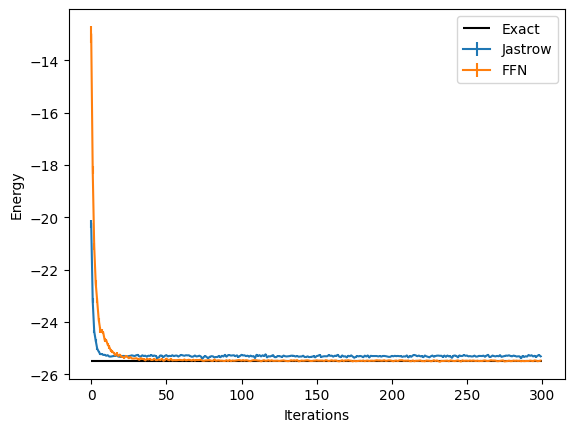

In [75]:
data_FFN = log.data

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma, label="Jastrow")
plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

## 7. Translation Symmetry 

In order to enforce spatial symmetries we can use some built-in functionalities of NetKet, in conjunction with equivariant layers. 

The first step is to construct explicitly a graph that contains the edges of our interactions, in this case this is a simple chain with periodic boundaries. NetKet has builtin several symmetry groups that can be used to target specific spatial symmetries. In this case for example after constructing the graph we can also print its translation group. 


In [76]:
graph=nk.graph.Chain(length=N, pbc=True)

print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([1]), Translation([2]), Translation([3]), Translation([4]), Translation([5]), Translation([6]), Translation([7]), Translation([8]), Translation([9]), Translation([10]), Translation([11]), Translation([12]), Translation([13]), Translation([14]), Translation([15]), Translation([16]), Translation([17]), Translation([18]), Translation([19])], degree=20)


Graphs are in general quite handy when defining hamiltonian terms on their edges. For example we can define our Hamiltonian as 

In [77]:
Gamma=-1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])

We now write a model with an invariant transformation given by the translation group. Notice that we will now use NetKet's own ```nn``` module, instead of Flax, since it contains several additions and also an extended and seamless support for complex layers/parameters.  

In [78]:
import flax.linen as nn
import netket.nn as nknn

class SymmModel(nn.Module):
    alpha: int

    @nn.compact
    def __call__(self, x):
        # add an extra dimension with size 1, because DenseSymm requires rank-3 tensors as inputs.
        # the shape will now be (batches, 1, Nsites)
        x = x.reshape(-1, 1, x.shape[-1])
        
        x = nknn.DenseSymm(symmetries=graph.translation_group(),
                           features=self.alpha,
                           kernel_init=nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))


sampler = nk.sampler.MetropolisLocal(hi)

#Let us define a model with 4 features per symmetry
model=SymmModel(alpha=4)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

vstate.n_parameters

84

As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model, using a few more optimization steps than before.  

In [79]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=600,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",symm_energy,error)

100%|███████████████████████████████████████████████████| 600/600 [00:27<00:00, 21.53it/s, Energy=-25.4886 ± 0.0014 [σ²=0.0025, R̂=1.0082, τ=0.9<2.1]]


Optimized energy and relative error:  -25.4903 ± 0.0016 [σ²=0.0025, R̂=1.0143, τ=1.0<4.6] 2.7001155950290246e-05


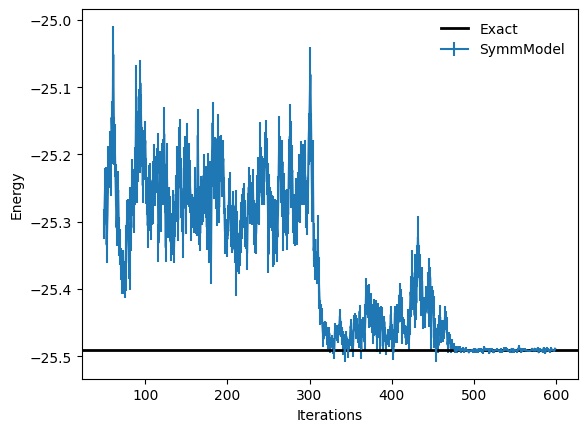

In [80]:
plt.errorbar(log.data["Energy"].iters[50:],log.data["Energy"].Mean[50:],yerr=log.data["Energy"].Sigma[50:],label="SymmModel")

plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

## 8. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could decide to measure the value of the nearest-neighbor $X-X$ correlator. 
Notice that since correlators do not enjoy the zero-variance principle as the Hamiltonian instead does, it is important to use a larger number of samples to have a sufficiently low error bar on their measurement. 


In [81]:
corr = sum([sigmax(hi,i)*sigmax(hi,j) for (i,j) in graph.edges()])

In [82]:
vstate.n_samples=400000

In [83]:
vstate.expect(corr)

10.909 ± 0.021 [σ²=31.497, R̂=1.0002, τ=3.8<4.0]

And we can further compare this to the exact ED result. 

In [84]:
psi = eig_vecs[:, 0]
exact_corr=psi@(corr@psi)
print(exact_corr)

10.852248713127992
